# Scraping sobre ai-jobs.net

## Librerias

In [1200]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from itertools import zip_longest

import missingno as msno

from sklearn.preprocessing import LabelEncoder
import re

## Conexión a JOBS_URL

In [1201]:
# pagina de ai-jobs.net sobre analyst, etc.
JOBS_URL = 'https://ai-jobs.net/?cat=12&cat=10&cat=3&cat=6&cat=2&cat=5&cat=15&cat=16&key=&exp='

In [1202]:
# conectarse a la URL
response = requests.get(JOBS_URL)

In [1203]:
try:
    response = requests.get(JOBS_URL)
    response.raise_for_status()  # Lanza una excepción si el código de estado no es 200
    print('Conectado...')
except requests.exceptions.HTTPError as err:
    print(f'Error: {err}')
except requests.exceptions.RequestException as e:
    print(f'Error de conexión: {e}')

Conectado...


## BeautifulSoup

In [1204]:
soup = BeautifulSoup(response.content, 'html.parser')

In [1205]:
results = soup.find('ul', {'class':'list-group list-group-flush mb-4'}).find_all('li', {'class': 'list-group-item list-group-item-action p-1'})

results[0]

<li class="list-group-item list-group-item-action p-1">
<div class="row">
<div class="col-2 col-sm-1 py-2">
<a href="/jobs-at-the-wild-neighbors-database-project/" title="Show all open positions at The Wild Neighbors Database Project">
<img alt="The Wild Neighbors Database Project logo" class="mx-auto my-1 d-block" height="48" loading="lazy" src="/media/cache/b3/99/b399910c288f467c84225492514893ba.jpg" width="48"/>
</a>
<div class="d-flex justify-content-center mt-3">
<a class="btn-direct-apply text-body-emphasis p-1" href="mailto:devin.dombrowski@wildneighborsdp.org?subject=Remote%20AI/ML%20Engineer%20in%20Wildlife%20Conservation at The%20Wild%20Neighbors%20Database%20Project (via ai-jobs.net)" id="47153" title="Apply for this job directly via email: devin.dombrowski@wildneighborsdp.org"><i class="fas fa-edit"></i></a>
<a class="btn-direct-apply text-body-emphasis p-1" href="/job/mark/47153/create/" rel="nofollow" title="Save this job for later application"><i class="fas fa-list-ol"><

### Glosario
- jobs_title = publicacion de trabajo
- level = Senior, Junior, etc
- job_type = fulltime, freelance, etc
- salary_range = en dolar
- benefits = beneficios auxiliares
- onsite_remote = si es o no remoto
- category_name =  data engineer, etc
- company_name = nombre de la empresa
- location_name = pais
- skill_name = python, sql, etc

### Buscamos uno por uno las etiquetas

In [1206]:
jobs_title = results[0].find('h3', {'class': 'h5 mb-2 text-body-emphasis'}).get_text()
jobs_title

'Remote AI/ML Engineer in Wildlife Conservation'

In [1207]:
level = results[1].find('span', {'class': 'badge rounded-pill text-bg-info my-md-1 d-none d-md-inline-block'}).get_text()
level

'Senior-level'

In [1208]:
job_type = results[0].find('span', {'class': 'badge rounded-pill text-bg-secondary my-md-1 ms-1'}).get_text()
job_type

'Contract'

In [1209]:
salary_range = results[0].find('span', {'class': 'badge rounded-pill text-bg-success d-none d-md-inline-block'}).get_text()
salary_range

'USD 25K - 30K'

In [1210]:
# tener cuidado con los datos faltantes
def benefits_list():
    for result in results:
        benefits = results[4].find_all('span', {'class': 'badge rounded-pill text-bg-success'})
    for benefit in benefits:
        print(benefit.get_text())
# benefits

In [1211]:
# En esta pagina se encuentra en el dato del pais. hay que encontrar esa "remote" en la seccion de location_name
# onsite_remote

In [1212]:
# Hay que encontrarlo dentro de "jobs_title"
# category_name

In [1213]:
company_name = results[1].find('p', {'class': 'm-0 text-muted'}).get_text()
company_name

'White Wind Research'

In [1214]:
location_name = results[0].find('span', {'class': 'd-none d-md-block text-break'}).get_text()
location_name

'Remote, US'

In [1215]:
for result in results:
    skill_names = result.find_all('span', {'class': 'badge rounded-pill text-bg-light'})
for skill_name in skill_names:
    print(skill_name.get_text())
# skill_names

Machine Learning
Research


In [1216]:
### Crear un DataFrame con las etiquetas que se vieron arriba

In [1217]:
# Crear Listas

# tabla fact
job_title = []
level = []
job_type = []
salary_range = []
benefits = []
onsite_remote = []

# tablas dims
company_name = []
location_name = []
category_name = []
skill_name = []

In [1218]:
# Crear un loop para extraer cada fila de data
for result in results:
    try:
        job_title.append(result.find('h3', {'class': 'h5 mb-2 text-body-emphasis'}).get_text()) 
    except:
        job_title.append('n/a')
    
    try:
        level.append(result.find('span', {'class': 'badge rounded-pill text-bg-info my-md-1 d-none d-md-inline-block'}).get_text()) 
    except:
        level.append('n/a')
    
    try:
        job_type.append(result.find('span', {'class': 'badge rounded-pill text-bg-secondary my-md-1 ms-1'}).get_text()) 
    except:
        job_type.append('n/a')
    
    
    try:
        salary_range.append(result.find('span', {'class': 'badge rounded-pill text-bg-success d-none d-md-inline-block'}).get_text()) 
    except:
        salary_range.append('n/a')
    
    try:
        benefits_list = [x.get_text() for x in result.find_all('span', {'class': 'badge rounded-pill text-bg-success'})]
        if not benefits_list:
            benefits.append('n/a')
        else:
            benefits_str = ', '.join(benefits_list)
            benefits.append(benefits_str)
    except:
        benefits.append('n/a')

    
    
    
    
    try:
        company_name.append(result.find('p', {'class': 'm-0 text-muted'}).get_text()) 
    except:
        company_name.append('n/a')
    
    try:
        location_name.append(result.find('span', {'class': 'd-none d-md-block text-break'}).get_text()) 
    except:
        location_name.append('n/a')
    
    try:
        skill_name_list = [x.get_text() for x in result.find_all('span', {'class': 'badge rounded-pill text-bg-light'})]
        if not skill_name_list:
            skill_name.append('n/a')
        else:
            skill_name_str = ', '.join(skill_name_list)
            skill_name.append(skill_name_str)
    except:
        skill_name.append('n/a')
    
    # try:
    #     skill_name.append([x.get_text() for x in result.find_all('span', {'class': 'badge rounded-pill text-bg-light'})])
    # except:
    #     skill_name.append('n/a')
print(skill_name[0])

APIs, Classification, Data management, GitHub, Keras, Machine Learning, ML models, +6


### Tabla

In [1219]:
# Agrupar listas en tuplas con zip_longest
data = zip_longest(job_title, level, job_type, salary_range, benefits, company_name, location_name, skill_name)

# Crear DataFrame directamente desde las tuplas
df = pd.DataFrame(data, columns=['job_title', 'level', 'job_type', 'salary_range', 'benefits', 'company_name', 'location_name', 'skill_name'])

In [1220]:
data = []

for row in df.itertuples(index=False):
    data.append(list(row))

data = list(zip_longest(*data, fillvalue='n/a')) 

JOB = pd.DataFrame({
    'job_title': data[0],
    'level': data[1],
    'job_type': data[2],
    'salary_range': data[3],
    'benefits': data[4],
    'company_name': data[5],
    'location_name': data[6],
    'skill_name': data[7]
})

In [1221]:
# print(JOB)

## Normalizacón

In [1222]:
JOB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   job_title      95 non-null     object
 1   level          95 non-null     object
 2   job_type       95 non-null     object
 3   salary_range   95 non-null     object
 4   benefits       95 non-null     object
 5   company_name   95 non-null     object
 6   location_name  95 non-null     object
 7   skill_name     95 non-null     object
dtypes: object(8)
memory usage: 6.1+ KB


In [1223]:
JOB.isnull()

job_title  level  job_type  salary_range  benefits  company_name  \
0       False  False     False         False     False         False   
1       False  False     False         False     False         False   
2       False  False     False         False     False         False   
3       False  False     False         False     False         False   
4       False  False     False         False     False         False   
..        ...    ...       ...           ...       ...           ...   
90      False  False     False         False     False         False   
91      False  False     False         False     False         False   
92      False  False     False         False     False         False   
93      False  False     False         False     False         False   
94      False  False     False         False     False         False   

    location_name  skill_name  
0           False       False  
1           False       False  
2           False       False  
3           False       False  
4           False       False  
..            ...         ...  
90          False       False  
91          False       False  
92          False       False  
93          False       False  
94          False       False  

[95 rows x 8 columns]

<Axes: >

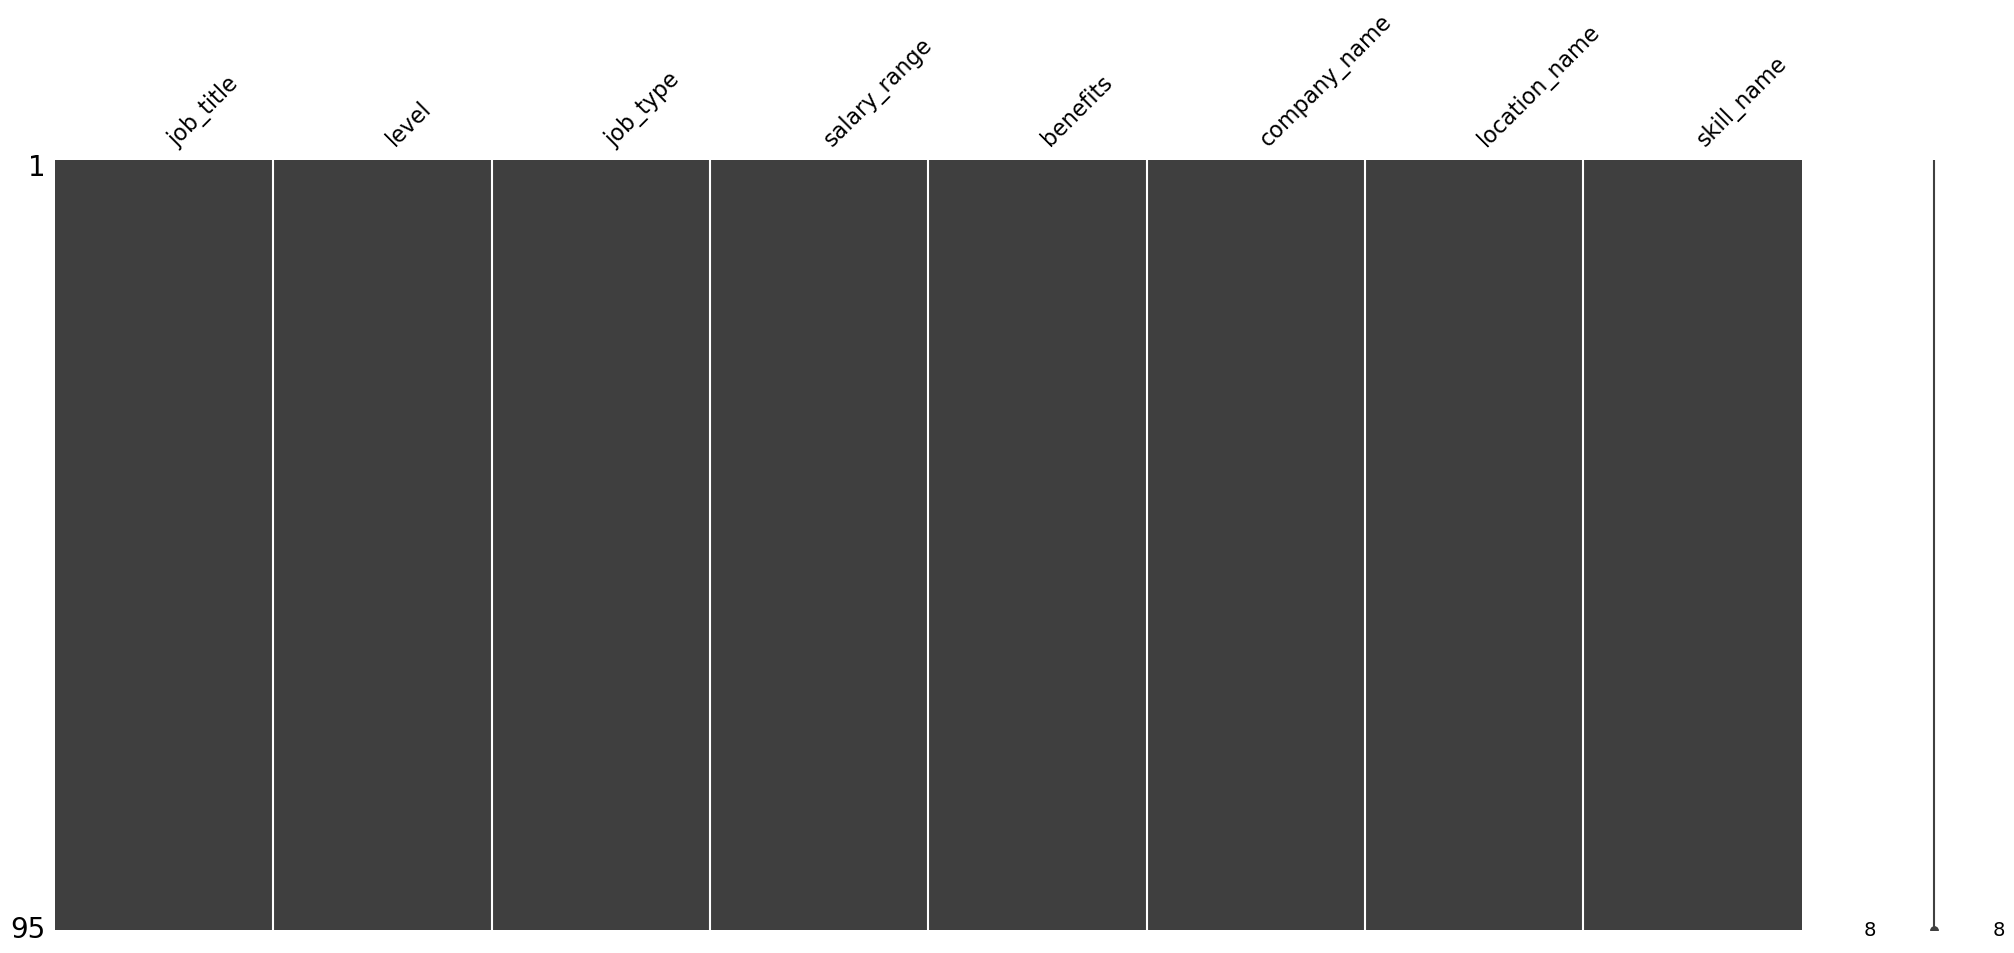

In [1224]:
# Visualizar los valores nulos en el dataframe
msno.matrix(df)

No tiene datos Nulos ya que en el scraping se establecio que si estaba nulo se llene con "n/a"

In [1225]:
# todo a minusculas
JOB = JOB.applymap(lambda x: x.lower() if type(x) == str else x)

In [1226]:
JOB.head(0)

Empty DataFrame
Columns: [job_title, level, job_type, salary_range, benefits, company_name, location_name, skill_name]
Index: []

In [1227]:
# Rango salarial. Agregar una nueva columna salary_avg que contenga el promedio del rango en tipo de dato float
def get_salary_avg(salary_range):
    """
    Función para extraer los valores numéricos de la cadena y calcular el promedio.
    """
    # Extraer los valores numéricos
    salaries = re.findall(r'\d+', salary_range)
    
    # Calcular el promedio
    if len(salaries) == 2:
        salary_avg = (int(salaries[0]) + int(salaries[1])) / 2
    else:
        salary_avg = 0
        
    return salary_avg

# Aplicar la función a la columna 'salary_range' y crear una nueva columna 'salary_avg'
JOB['salary_avg'] = JOB['salary_range'].apply(get_salary_avg)

# Eliminar la columna 'salary_range'
JOB.drop(columns=['salary_range'], inplace=True)

# Cambiar orden de las columnas y renombrar la columna 'salary_avg' a 'salary_range'
# JOB = JOB.reindex(columns=[
#     'job_title',
#     'category',
#     'job_type',
#     'onsite_remote',
#     'location_name',
#     'salary_range',
#     'company_name'
# ])

# JOB.columns = [
#     'job_title',
#     'category',
#     'job_type',
#     'onsite_remote',
#     'location_name',
#     'salary_range',
#     'company_name'
# ]


# Creamos un csv
# JOB.to_csv('JOB.csv', index=False)

### Codificar las variables categóricas utilizando técnicas como one-hot encoding o label encoding.

In [1228]:
# Crear dataframe de ejemplo
dim_JobCategory = pd.DataFrame({
    'category_name': [
        'Data Scientist',
        'Data Engineer',
        'Machine Learning',
        'Data Analyst',
        'Others'
    ],
    'type': [
        'Data Engineer',
        'Data Analyst',
        'ML',
        'Others',
        'None'
    ]})

# Aplicar one-hot encoding a la variable 'job_type'
job_type_dummies = pd.get_dummies(dim_JobCategory['type'], prefix='_')

# Unir las columnas dummies al dataframe original
dim_JobCategory = pd.concat([dim_JobCategory, job_type_dummies], axis=1)

# Eliminar la columna original 'job_type'
dim_JobCategory.drop('type', axis=1, inplace=True)

# Mostrar el resultado
print(dim_JobCategory)

      category_name  __Data Analyst  __Data Engineer  __ML  __None  __Others
0    Data Scientist               0                1     0       0         0
1     Data Engineer               1                0     0       0         0
2  Machine Learning               0                0     1       0         0
3      Data Analyst               0                0     0       0         1
4            Others               0                0     0       1         0


### Agrega una columna dim_JobCategory con el cargo extraido de 

In [1229]:
# Definir la expresión regular para encontrar los títulos que hagan match
regex = re.compile(r'(engineer|analyst|ml)', flags=re.IGNORECASE)

# Crear una nueva columna 'dim_JobCategory' en el dataframe JOB, asignando 'data scientist' como valor por defecto.
JOB['dim_JobCategory'] = 'data scientist'

# Asignar la categoría correspondiente a los títulos que hagan match con la expresión regular
JOB.loc[JOB['job_title'].str.contains(regex), 'dim_JobCategory'] = JOB['job_title'].str.extract(regex, expand=False).str.lower()

# Mostrar el resultado
# JOB

/tmp/ipykernel_75162/833218681.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  JOB.loc[JOB['job_title'].str.contains(regex), 'dim_JobCategory'] = JOB['job_title'].str.extract(regex, expand=False).str.lower()


In [1230]:
# Definir la expresión regular para encontrar los títulos que hagan match
regex = re.compile(r'(remote)', flags=re.IGNORECASE)

# Crear una nueva columna 'onsite_remote' en el dataframe JOB, asignando 'onsite' como valor por defecto
JOB['onsite_remote'] = 'onsite'

# Asignar la categoría correspondiente a los títulos que hagan match con la expresión regular
JOB.loc[JOB['location_name'].str.contains(regex), 'onsite_remote'] = JOB['location_name'].str.extract(regex, expand=False).str.lower()

# Cambiar orden de las columnas y renombrar a columna '
JOB = JOB.reindex(columns=[
    'job_title',
    'level',
    'job_type',
    'salary_avg',
    'benefits',
    'onsite_remote',
    'dim_JobCategory',
    'company_name',
    'location_name',
    'skill_name',   
    
])

JOB.columns = ([
    'job_title',
    'level',
    'job_type',
    'salary_avg',
    'benefits',
    'onsite_remote',
    'dim_JobCategory',
    'dim_Company',
    'dim_Location',
    'dim_Skills',
])

# Crea un csv con toda la info
JOB.to_csv('./data/job.csv', index=False)

/tmp/ipykernel_75162/3568789087.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  JOB.loc[JOB['location_name'].str.contains(regex), 'onsite_remote'] = JOB['location_name'].str.extract(regex, expand=False).str.lower()
